In [ ]:
import walnut

# Example 6

### Character level language model

The goal of this model is to be able to generate text that is similar to the training data.

### Step 1: Prepare data
You will need to download the dataset from https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt and place it into the *data* directory.

In [ ]:
with open("data/tinyshakespeare.txt", "r") as f:
    data = f.read()

To build a vocabulary of tokens, the `CharacterTokenizer` is used. In this step the `fit()` extracts tokens from the previously imported data. Here, a token is represented by a single a character.

In [ ]:
from walnut.preprocessing.text import CharacterTokenizer

tknzr = CharacterTokenizer()
tknzr.fit(data)
tknzr.vocab_size

Encode the data

In [ ]:
data_enc = tknzr.encode(data)
data_enc[:100]

Next up, we need to build the training dataset. `num_samples` represents the number of inputs for the neural network. `block_size` defines, how many characters are considered when trying to predict the following one.

In [ ]:
num_samples = 100000
block_size = 16

To use the dataset for training, the following steps must be performed:
- choose random samples from the data by randomly selecting a sequence of 8 characters for training and the 9th character as the target
- one-hot-encode tokens

In [ ]:
import numpy as np
from walnut.preprocessing.encoding import one_hot_encode

# initialize tensors with zeros
X = walnut.zeros((num_samples, block_size, tknzr.vocab_size))
Y = walnut.zeros((num_samples, tknzr.vocab_size))

#randomly choose indices of blocks in the original data
rand_indices = np.random.randint(0, len(data) - block_size, (num_samples,))

for i, index in enumerate(rand_indices):
    # get characters and the label from the data
    context = data_enc[index : index + block_size]
    label = walnut.match_dims(data_enc[index + block_size], 1)

    # one-hot-encode indices and add to the tensors
    X[i] = one_hot_encode(context, tknzr.vocab_size).data
    Y[i] = one_hot_encode(label, tknzr.vocab_size).data

Train/val/test split

In [ ]:
n1 = int(num_samples * 0.8)
n2 = int(n1 + num_samples * 0.1)

x_train = X[:n1]
y_train = Y[:n1]
x_val = X[n1:n2]
y_val = Y[n1:n2]
x_test = X[n2:]
y_test = Y[n2:]

print(f"{x_train.shape=}")
print(f"{y_train.shape=}")
print(f"{x_val.shape=}")
print(f"{y_val.shape=}")
print(f"{x_test.shape=}")
print(f"{y_test.shape=}")

### Step 2: Build the wavenet

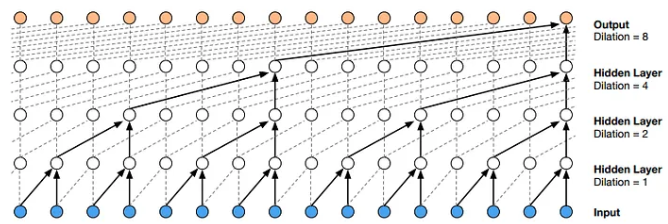

In [ ]:
import walnut.nn as nn
embed_dims = 10
n_hidden = 100


# wavenet-like
model = nn.Sequential(layers=[
    nn.modules.Embedding(embed_dims, input_shape=(block_size, tknzr.vocab_size)),
    nn.modules.Reshape((1, block_size, -1)), # insert fake dim for conv2d
    nn.modules.Convolution2d(1, (2, embed_dims), act="relu", norm="layer"), # casual conv
    nn.modules.Convolution2d(1, (2, 30), act="relu", norm="layer", dil=(2, 1)),
    nn.modules.Convolution2d(1, (2, 1), act="relu", norm="layer", dil=(4, 1)),
    nn.modules.Reshape(),
    nn.modules.Linear(tknzr.vocab_size, act="softmax", norm="layer")
])

In [ ]:
model.compile(nn.optimizers.Adam(l_r=1e-3), nn.losses.Crossentropy(), nn.metrics.Accuracy())
model

### Step 3: Train the model

Since there are usually quite a large number of classes (=tokens) in language models, the training process is slower.

In [ ]:
train_hist, val_hist = model.train(
    x_train,
    y_train,
    epochs=3000,
    batch_size=32,
    verbose="all",
    val_data=(x_val, y_val))

The training loss above only represents one batch. Below the model is evaluated on the entire training data.

In [ ]:
loss, accuracy = model.evaluate(x_train, y_train)
print(f'training loss {loss:.4f}')
print(f'training accuracy {accuracy:.4f}')

### Step 4: Evaluate the model

In [ ]:
loss, accuracy = model.evaluate(x_test, y_test)
print(f'loss {loss:.4f}')
print(f'accuracy {accuracy:.4f}')

# high scores:
# linear stack: accuracy 0.4304 after 10000 epochs (32 min)
# wave net-like: accuracy: 0.4058 after 5000 epochs (34 min)

### Step 5: Generate text
To see the model in action, it is given a starting sequence. Then it is used to generate $n$ characters using previous charactes as input. The better the model is trained, the more sensical the output will be. This can take quite a lot of training though.

In [ ]:
context = walnut.ones((block_size,)).astype("int") # use ones as startig context

for _ in range(300):
    context_enc = one_hot_encode(context, tknzr.vocab_size) # encode tokens
    context_enc = walnut.expand_dims(context_enc, 0) # create fake batch dim

    pred = model(context_enc) # get model prediction for a character
    index = walnut.choice(pred) # choose a character from prediction
    print(tknzr.decode(walnut.expand_dims(index, 0)), end="")

    context = context.append(index, axis=0).astype("int") # append predicted character
    context = context[1:] # set new context